## Breast Cancer Diagnosis Classification
### Supervised, Semi-Supervised, and Unsupervised Learning

### The analysis involves performing 50 Monte-Carlo simulations for each of:
    
    1. Supervised Learning: Training an L1-penalized SVM to classify the data using 5 fold cross validation to choose the penalty parameter
    
    2. Semi-Supervised Learning/ Self-training: Randomly selecting 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data
    
    3. Unsupervised Learning: Running k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2
    
    4. Spectral Clustering: Performing clustering based on kernels and labelling data using fit-predict method

## Importing necessary packages

In [657]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import sklearn.metrics as metrics

import warnings # Package to ignore warnings
warnings.filterwarnings('ignore')

import random
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

## UDFs

In [2]:
def fn_test_train_split(test_size=0.2):

    '''Test size is the only parameter needed to pass into the function with default 0.2
    This function splits the breast cancer dataset into test-train and returns 4 outputs:
        a. X Train
        b. X Test
        c. y Train
        d. y Test
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(cancer_data.drop(['id','class'], axis=1), 
                                                    cancer_data[['class']],
                                                    test_size=0.2,
                                                    stratify=cancer_data['class']
                                                   )
    return(X_train, X_test, y_train, y_test)

In [386]:
def fn_roc_auc(FPR, TPR):
    
    '''Function to create ROC curve - Inputs are FPR, TPR'''
    
    plt.plot(FPR, TPR)
    plt.plot([0,1],[0,1])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    
    plt.show()

## Supervised, Semi-Supervised, and Unsupervised Learning

### a) Download the Breast Cancer Wisconsin Data

In [4]:
cancer_data = pd.read_csv('../data/wdbc.data', header=None)

In [5]:
# Since column names are not available, naming them arbitrarily
var_name_list = ['id', 'class']

for i in range(1,31):
    temp_name = 'v' + str(i)
    var_name_list.append(temp_name)
    
print(len(var_name_list))

32


In [6]:
cancer_data.columns = var_name_list

In [7]:
cancer_data.shape

(569, 32)

In [8]:
cancer_data.tail(2)

,id,class,v1,v2,v3,v4,v5,v6,v7,v8,...,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.3514,0.152,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.265,0.4087,0.12400
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.0000,0.000,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.000,0.2871,0.07039


In [9]:
cancer_data['class'].value_counts()

B    357
M    212
Name: class, dtype: int64

### b) Monte-Carlo simulation

#### i) Supervised Learning

**Test Data** 

Confusion matrix: [[72  0]
 [ 2 40]]


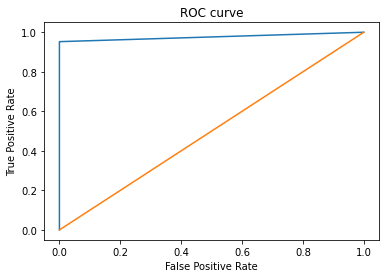

Average scores:
Accuracy - 0.9725146198830407
Precision - 0.9729963626929183
Recall - 0.9842592592592591
F1 Score - 0.9783980265622397
AUC - 0.9683201058201056


**Train Data**
Confusion matrix: [[284   1]
 [  6 164]]


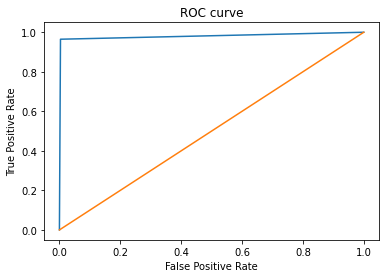

Average scores:
Accuracy - 0.9842490842490843
Precision - 0.9806466987445285
Recall - 0.994502923976608
F1 Score - 0.9875202021130299
AUC - 0.98078087375301


In [388]:
accuracy_list_train = []
precision_list_train = []
recall_list_train = []
fscore_list_train = []
auc_list_train = []

accuracy_list_test = []
precision_list_test = []
recall_list_test = []
fscore_list_test = []
auc_list_test = []

for i in range(1,31):
    
    # Splitting data into train-test parts in 80:20 ratio randomly
    X_train, X_test, y_train, y_test = fn_test_train_split()
    
    # Normalizing the data
    standarization = StandardScaler()
    
    # Train data
    train_std = standarization.fit(X_train)
    X_train_trf = train_std.transform(X_train)
    
    # Test data
    test_std = standarization.fit(X_test)
    X_test_trf = train_std.transform(X_test)
    
    # Model
    m_svm_l1 = LinearSVC(penalty='l1',dual=False)
    m_svm_l1 = GridSearchCV(estimator=m_svm_l1, param_grid={'C': np.logspace(-6,12,24), 'tol':[0.0001,0.00001,0.000001] } ,cv=5)
    m_svm_l1.fit(X_train_trf, y_train['class'])
    
    dict_labels = {'B': 0, 'M': 1}
    
    # Test Data: Predict
    y_pred_l1_svm = m_svm_l1.predict(X_test_trf)
    accuracy_list_test.append(metrics.accuracy_score(y_test['class'],y_pred_l1_svm))
    precision_list_test.append(metrics.precision_score(y_test['class'],y_pred_l1_svm, pos_label='B'))
    recall_list_test.append(metrics.recall_score(y_test['class'],y_pred_l1_svm, pos_label='B'))
    fscore_list_test.append(metrics.f1_score(y_test['class'],y_pred_l1_svm, pos_label='B'))

    
    y_int = y_test['class'].map(dict_labels)
    y_pred_int = pd.Series(y_pred_l1_svm).map(dict_labels)
    fpr, tpr, thresholds = metrics.roc_curve(y_int, y_pred_int)
    auc_list_test.append(metrics.auc(fpr, tpr))
    
    if i == 30:
        print('**Test Data** \n')
        
        confusion_matrix_test = metrics.confusion_matrix(y_test['class'], y_pred_l1_svm)
        print(f'Confusion matrix: {confusion_matrix_test}')
        fn_roc_auc(fpr, tpr)
        
        print(f'Average scores:')
        print(f'Accuracy - {sum(accuracy_list_test)/len(accuracy_list_test)}')
        print(f'Precision - {sum(precision_list_test)/len(precision_list_test)}')
        print(f'Recall - {sum(recall_list_test)/len(recall_list_test)}')
        print(f'F1 Score - {sum(fscore_list_test)/len(fscore_list_test)}')
        print(f'AUC - {sum(auc_list_test)/len(auc_list_test)}')
        
    # Train Data: Predict
    y_pred_l1_svm = m_svm_l1.predict(X_train_trf)
    accuracy_list_train.append(metrics.accuracy_score(y_train['class'],y_pred_l1_svm))
    precision_list_train.append(metrics.precision_score(y_train['class'],y_pred_l1_svm, pos_label='B'))
    recall_list_train.append(metrics.recall_score(y_train['class'],y_pred_l1_svm, pos_label='B'))
    fscore_list_train.append(metrics.f1_score(y_train['class'],y_pred_l1_svm, pos_label='B'))
    
    y_int = y_train['class'].map(dict_labels)
    y_pred_int = pd.Series(y_pred_l1_svm).map(dict_labels)
    fpr, tpr, thresholds = metrics.roc_curve(y_int, y_pred_int)
    auc_list_train.append(metrics.auc(fpr, tpr))
    
    if i == 30:
        print('\n\n**Train Data**')
        
        confusion_matrix_train = metrics.confusion_matrix(y_train['class'], y_pred_l1_svm)
        print(f'Confusion matrix: {confusion_matrix_train}')
        fn_roc_auc(fpr, tpr)
    
        print(f'Average scores:')
        print(f'Accuracy - {sum(accuracy_list_train)/len(accuracy_list_train)}')
        print(f'Precision - {sum(precision_list_train)/len(precision_list_train)}')
        print(f'Recall - {sum(recall_list_train)/len(recall_list_train)}')
        print(f'F1 Score - {sum(fscore_list_train)/len(fscore_list_train)}')
        print(f'AUC - {sum(auc_list_train)/len(auc_list_train)}')


#### ii) Semi-Supervised Learning

**Test Data** 

Confusion matrix: [[39 33]
 [ 0 42]]


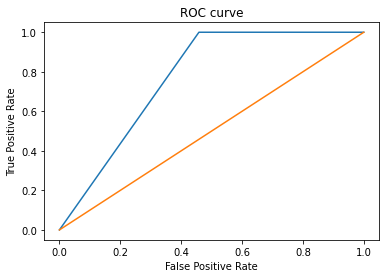

Average scores:
Accuracy - 0.7105263157894737
Precision - 1.0
Recall - 0.5416666666666666
F1 Score - 0.7027027027027027
AUC - 0.7708333333333334


**Train Data**
Confusion matrix: [[ 80 205]
 [ 48 122]]


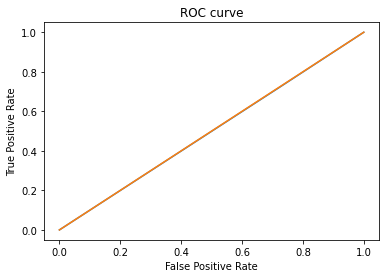

Average scores:
Accuracy - 0.44395604395604393
Precision - 0.625
Recall - 0.2807017543859649
F1 Score - 0.387409200968523
AUC - 0.4991744066047472


In [988]:
for i in range(1,31):
    
    # Obtaining train test datasets
    X_train, X_test, y_train, y_test = fn_test_train_split()

    # Splitting data into 50% each 

    b_label_index = y_train[y_train['class'] == 'B'].index.tolist()
    random.shuffle(b_label_index) #Ensuring randomization
    b_label_index_half = b_label_index[0:int(len(b_label_index)/2)]
    b_label_index_2nd_half = b_label_index[int(len(b_label_index)/2):]

    m_label_index = y_train[y_train['class'] == 'M'].index.tolist()
    random.shuffle(m_label_index)
    m_label_index_half = m_label_index[0:int(len(m_label_index)/2)]
    m_label_index_2nd_half = m_label_index[int(len(m_label_index)/2):]

    # Separating labeled and unlabeled data

    #Labeled Data
    y_train_b_label = y_train.filter(items = b_label_index_half, axis=0)
    y_train_m_label = y_train.filter(items = m_label_index_half, axis=0)
    y_train_label = y_train_b_label.append(y_train_m_label)

    X_train_b_label = X_train.filter(items = b_label_index_half, axis=0)
    X_train_m_label = X_train.filter(items = m_label_index_half, axis=0)
    X_train_label = X_train_b_label.append(X_train_m_label)

    #Non-Labeled Data
    y_train_b_nonlabel = y_train.filter(items = b_label_index_2nd_half, axis=0)
    y_train_m_nonlabel = y_train.filter(items = m_label_index_2nd_half, axis=0)
    y_train_nonlabel = y_train_b_nonlabel.append(y_train_m_nonlabel)

    X_train_b_nonlabel = X_train.filter(items = b_label_index_2nd_half, axis=0)
    X_train_m_nonlabel = X_train.filter(items = m_label_index_2nd_half, axis=0)
    X_train_nonlabel = X_train_b_nonlabel.append(X_train_m_nonlabel)

    # Normalizing the data
    standarization = StandardScaler()

    # Train data
    train_std = standarization.fit(X_train_label)
    X_train_trf = train_std.transform(X_train_label)

    # Test data
    test_std = standarization.fit(X_test)
    X_test_trf = train_std.transform(X_test)

    # Model

    m_svm_l1_semi = LinearSVC(penalty='l1',dual=False)
    m_svm_l1_semi = GridSearchCV(estimator=m_svm_l1_semi, param_grid={'C': np.logspace(-6,12,24), 'tol':[0.0001,0.00001,0.000001] } ,cv=5)
    m_svm_l1_semi.fit(X_train_trf, y_train_label['class'])


    X_train_nonlabel_deduct = X_train_nonlabel.copy() 

    while len(X_train_nonlabel_deduct) > 0:   
        dist_list = list(m_svm_l1_semi.decision_function(X_train_nonlabel_deduct))
        dist_farthest = max(dist_list)
        dist_fathest_index = dist_list.index(dist_farthest)

        tempx = pd.DataFrame(X_train_nonlabel_deduct.iloc[dist_fathest_index-1]).T
        pred_y_unlabel = m_svm_l1_semi.predict(tempx)[0]

        X_train_label = X_train_label.append(tempx)
        y_train_label = y_train_label.append({'class': pred_y_unlabel[0]}, ignore_index=True)

        train_std = standarization.fit(X_train_label)
        X_train_trf = train_std.transform(X_train_label)

        m_svm_l1_semi = LinearSVC(penalty='l1',dual=False)
        m_svm_l1_semi = GridSearchCV(estimator=m_svm_l1_semi, param_grid={'C': np.logspace(-3,6,8), 'tol':[0.0001,0.000001] } ,cv=5)
        m_svm_l1_semi.fit(X_train_trf, y_train_label['class'])

        X_train_nonlabel_deduct.drop(index=tempx.index[0], inplace= True)

    accuracy_list_train = []
    precision_list_train = []
    recall_list_train = []
    fscore_list_train = []
    auc_list_train = []

    accuracy_list_test = []
    precision_list_test = []
    recall_list_test = []
    fscore_list_test = []
    auc_list_test = []

    dict_labels = {'B': 0, 'M': 1}

    # Test Data: Predict
    y_pred_l1_svm_semi = m_svm_l1_semi.predict(X_test_trf)
    accuracy_list_test.append(metrics.accuracy_score(y_test['class'],y_pred_l1_svm_semi))
    precision_list_test.append(metrics.precision_score(y_test['class'],y_pred_l1_svm_semi, pos_label='B'))
    recall_list_test.append(metrics.recall_score(y_test['class'],y_pred_l1_svm_semi, pos_label='B'))
    fscore_list_test.append(metrics.f1_score(y_test['class'],y_pred_l1_svm_semi, pos_label='B'))

    y_int = y_test['class'].map(dict_labels)
    y_pred_int = pd.Series(y_pred_l1_svm_semi).map(dict_labels)
    fpr, tpr, thresholds = metrics.roc_curve(y_int, y_pred_int)
    auc_list_test.append(metrics.auc(fpr, tpr))

    if i == 30:
        print('**Test Data** \n')

        confusion_matrix_test = metrics.confusion_matrix(y_test['class'], y_pred_l1_svm_semi)
        print(f'Confusion matrix: {confusion_matrix_test}')
        fn_roc_auc(fpr, tpr)

        print(f'Average scores:')
        print(f'Accuracy - {sum(accuracy_list_test)/len(accuracy_list_test)}')
        print(f'Precision - {sum(precision_list_test)/len(precision_list_test)}')
        print(f'Recall - {sum(recall_list_test)/len(recall_list_test)}')
        print(f'F1 Score - {sum(fscore_list_test)/len(fscore_list_test)}')
        print(f'AUC - {sum(auc_list_test)/len(auc_list_test)}')

    # Train Data: Predict
    y_pred_l1_svm_semi = m_svm_l1_semi.predict(X_train_trf)
    accuracy_list_train.append(metrics.accuracy_score(y_train['class'],y_pred_l1_svm_semi))
    precision_list_train.append(metrics.precision_score(y_train['class'],y_pred_l1_svm_semi, pos_label='B'))
    recall_list_train.append(metrics.recall_score(y_train['class'],y_pred_l1_svm_semi, pos_label='B'))
    fscore_list_train.append(metrics.f1_score(y_train['class'],y_pred_l1_svm_semi, pos_label='B'))

    y_int = y_train['class'].map(dict_labels)
    y_pred_int = pd.Series(y_pred_l1_svm_semi).map(dict_labels)
    fpr, tpr, thresholds = metrics.roc_curve(y_int, y_pred_int)
    auc_list_train.append(metrics.auc(fpr, tpr))

    if i == 30:
        print('\n\n**Train Data**')

        confusion_matrix_train = metrics.confusion_matrix(y_train['class'], y_pred_l1_svm_semi)
        print(f'Confusion matrix: {confusion_matrix_train}')
        fn_roc_auc(fpr, tpr)

        print(f'Average scores:')
        print(f'Accuracy - {sum(accuracy_list_train)/len(accuracy_list_train)}')
        print(f'Precision - {sum(precision_list_train)/len(precision_list_train)}')
        print(f'Recall - {sum(recall_list_train)/len(recall_list_train)}')
        print(f'F1 Score - {sum(fscore_list_train)/len(fscore_list_train)}')
        print(f'AUC - {sum(auc_list_train)/len(auc_list_train)}')

#### iii) Unsupervised Learning

- We can ensure that the algorithm was not trapped in a local minima by running the algorithm multiple times and initializing it randomly

**Train Data**

Confusion matrix: 
 [[284   1]
 [ 67 103]]


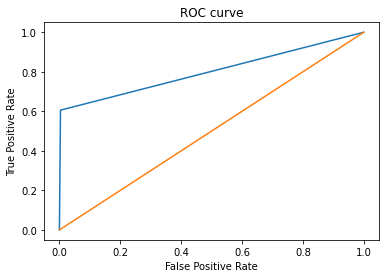

Average scores:
Accuracy - 0.84967032967033
Precision - 0.9919935191039234
Recall - 0.6025490196078429
F1 Score - 0.7494722260262587
AUC - 0.799812521499828


In [558]:
accuracy_list_train = []
precision_list_train = []
recall_list_train = []
fscore_list_train = []
auc_list_train = []

for i in range(1,31):
    
    X_train, X_test, y_train, y_test = fn_test_train_split()
    X_train_dup = X_train.copy()
    
    kmeans = KMeans(n_clusters=2, init='random').fit(X_train)
    kmeans_pred = kmeans.predict(X_train)
    X_train_dup['cluster'] = kmeans.labels_
    
    
    # Computing cluster centers & calculating distance
    cc = kmeans.cluster_centers_
    temp0 = np.reshape(cc[0], (1,-1))
    temp1 = np.reshape(cc[1], (1,-1))
    
    X_train_dup['dist0'] = euclidean_distances(X_train, temp0)
    X_train_dup['dist1'] = euclidean_distances(X_train, temp1)
    
    top30_cluster0_index = list(X_train_dup[X_train_dup['cluster'] == 0]['dist0'].sort_values().index[0:30])
    top30_cluster1_index = list(X_train_dup[X_train_dup['cluster'] == 1]['dist1'].sort_values().index[0:30])
    
    majority_label_c0 = y_train.filter(items = top30_cluster0_index, axis=0).value_counts().sort_values().index[-1][0]
    majority_label_c1 = y_train.filter(items = top30_cluster1_index, axis=0).value_counts().sort_values().index[-1][0]
    
    pred_label = []
    
    for p in range(len(X_train)):
        if X_train_dup[['cluster']].iloc[p][0] == 0:
            pred_label.append(majority_label_c0)
        else:
            pred_label.append(majority_label_c1)
    pred_label = pd.Series(pred_label)
    
    
    y_int = y_train['class'].map(dict_labels)
    y_pred_int = pred_label.map(dict_labels)
    fpr, tpr, thresholds = metrics.roc_curve(y_int, y_pred_int)
    auc_list_train.append(metrics.auc(fpr, tpr))
    
    accuracy_list_train.append(metrics.accuracy_score(y_int, y_pred_int))
    precision_list_train.append(metrics.precision_score(y_int, y_pred_int))
    recall_list_train.append(metrics.recall_score(y_int, y_pred_int))
    fscore_list_train.append(metrics.f1_score(y_int, y_pred_int))


    if i == 30:
        print('**Train Data**\n')

        confusion_matrix_train = metrics.confusion_matrix(y_int, y_pred_int)
        print(f'Confusion matrix: \n {confusion_matrix_train}')
        fn_roc_auc(fpr, tpr)

        print(f'Average scores:')
        print(f'Accuracy - {sum(accuracy_list_train)/len(accuracy_list_train)}')
        print(f'Precision - {sum(precision_list_train)/len(precision_list_train)}')
        print(f'Recall - {sum(recall_list_train)/len(recall_list_train)}')
        print(f'F1 Score - {sum(fscore_list_train)/len(fscore_list_train)}')
        print(f'AUC - {sum(auc_list_train)/len(auc_list_train)}')


**Test Data**

Confusion matrix: 
 [[72  0]
 [12 30]]


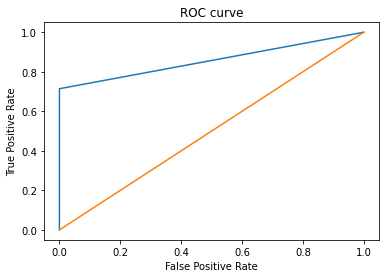

Average scores:
Accuracy - 0.8529239766081874
Precision - 0.9885985635232948
Recall - 0.6079365079365078
F1 Score - 0.7491181127220847
AUC - 0.8018849206349206


In [557]:
accuracy_list_test = []
precision_list_test = []
recall_list_test = []
fscore_list_test = []
auc_list_test = []

for i in range(1,31):
        
    X_train, X_test, y_train, y_test = fn_test_train_split()
    X_test_dup = X_test.copy()
    
    kmeans = KMeans(n_clusters=2, init='random').fit(X_test)
    kmeans_pred = kmeans.predict(X_test)
    X_test_dup['cluster'] = kmeans.labels_
    
    
    # Computing cluster centers & calculating distance
    cc = kmeans.cluster_centers_
    temp0 = np.reshape(cc[0], (1,-1))
    temp1 = np.reshape(cc[1], (1,-1))
    
    X_test_dup['dist0'] = euclidean_distances(X_test, temp0)
    X_test_dup['dist1'] = euclidean_distances(X_test, temp1)
    
    top30_cluster0_index = list(X_test_dup[X_test_dup['cluster'] == 0]['dist0'].sort_values().index[0:30])
    top30_cluster1_index = list(X_test_dup[X_test_dup['cluster'] == 1]['dist1'].sort_values().index[0:30])
    
    majority_label_c0 = y_test.filter(items = top30_cluster0_index, axis=0).value_counts().sort_values().index[-1][0]
    majority_label_c1 = y_test.filter(items = top30_cluster1_index, axis=0).value_counts().sort_values().index[-1][0]
    
    pred_label = []
    
    for p in range(len(X_test)):
        if X_test_dup[['cluster']].iloc[p][0] == 0:
            pred_label.append(majority_label_c0)
        else:
            pred_label.append(majority_label_c1)
    pred_label = pd.Series(pred_label)
    
    
    y_int = y_test['class'].map(dict_labels)
    y_pred_int = pred_label.map(dict_labels)
    fpr, tpr, thresholds = metrics.roc_curve(y_int, y_pred_int)
    auc_list_test.append(metrics.auc(fpr, tpr))
    
    accuracy_list_test.append(metrics.accuracy_score(y_int, y_pred_int))
    precision_list_test.append(metrics.precision_score(y_int, y_pred_int))
    recall_list_test.append(metrics.recall_score(y_int, y_pred_int))
    fscore_list_test.append(metrics.f1_score(y_int, y_pred_int))


    if i == 30:
        print('**Test Data**\n')

        confusion_matrix_train = metrics.confusion_matrix(y_int, y_pred_int)
        print(f'Confusion matrix: \n {confusion_matrix_train}')
        fn_roc_auc(fpr, tpr)

        print(f'Average scores:')
        print(f'Accuracy - {sum(accuracy_list_test)/len(accuracy_list_train)}')
        print(f'Precision - {sum(precision_list_test)/len(precision_list_test)}')
        print(f'Recall - {sum(recall_list_test)/len(recall_list_test)}')
        print(f'F1 Score - {sum(fscore_list_test)/len(fscore_list_test)}')
        print(f'AUC - {sum(auc_list_test)/len(auc_list_test)}')
        
    

#### iv) Spectral Learning



**Train Data**
Confusion matrix: [[285   0]
 [170   0]]


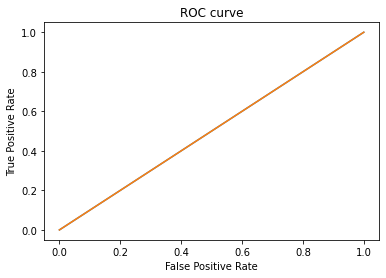

Average scores:
Accuracy - 0.6298168498168498
Precision - 0.3349396135265701
Recall - 0.013529411764705882
F1 Score - 0.024939196436055834
AUC - 0.5054781561747506


In [563]:
accuracy_list_train = []
precision_list_train = []
recall_list_train = []
fscore_list_train = []
auc_list_train = []
    
for i in range(1,31):
    X_train, X_test, y_train, y_test = fn_test_train_split()
    
    # Normalizing the data
    standarization = StandardScaler()
    
    # Train data
    train_std = standarization.fit(X_train)
    X_train_trf = train_std.transform(X_train)
    
    # Test data
    test_std = standarization.fit(X_test)
    X_test_trf = train_std.transform(X_test)
    
    spectral_model = SpectralClustering(n_clusters=2, affinity='rbf', gamma=1, assign_labels='discretize')
    spectral_model_label = spectral_model.fit_predict(X_train_trf)
    
    # Using KNN classifier to assist with majority polling
    knn_model = KNeighborsClassifier(n_neighbors=4)
    knn_model.fit(X_train_trf, spectral_model_label)
    knn_model_label = knn.predict(X_test_trf)
    
    
    train_rows = X_train_trf.shape[0]
    test_rows = X_test_trf.shape[0]
    y_train_pred = np.zeros(train_rows) #Initializing with zeros
    y_test_pred = np.zeros(test_rows)
    y_train_int = y_train['class'].map(dict_labels) # Mapping string to number

    for num_clusters in range(0,2):

        # For each cluster, assigning the labels
        spectral_index = np.where(spectral_model_label == num_clusters)
        knn_index = np.where(knn_model_label == num_clusters)

        majority_label = y_train_int.iloc[knn_index].value_counts().sort_values().index[-1]

        y_train_pred[spectral_index] = majority_label
        y_test_pred[knn_index] = majority_label
    
    accuracy_list_train.append(metrics.accuracy_score(y_train_int,y_train_pred))
    precision_list_train.append(metrics.precision_score(y_train_int,y_train_pred))
    recall_list_train.append(metrics.recall_score(y_train_int,y_train_pred))
    fscore_list_train.append(metrics.f1_score(y_train_int,y_train_pred))
    
    fpr, tpr, thresholds = metrics.roc_curve(y_train_int, y_train_pred)
    auc_list_train.append(metrics.auc(fpr, tpr))    
    
    if i == 30:
        print('\n\n**Train Data**')
        
        confusion_matrix_train = metrics.confusion_matrix(y_train_int, y_train_pred)
        print(f'Confusion matrix: {confusion_matrix_train}')
        fn_roc_auc(fpr, tpr)
    
        print(f'Average scores:')
        print(f'Accuracy - {sum(accuracy_list_train)/len(accuracy_list_train)}')
        print(f'Precision - {sum(precision_list_train)/len(precision_list_train)}')
        print(f'Recall - {sum(recall_list_train)/len(recall_list_train)}')
        print(f'F1 Score - {sum(fscore_list_train)/len(fscore_list_train)}')
        print(f'AUC - {sum(auc_list_train)/len(auc_list_train)}')

#### v) Comparing all model results obtained above

The average scores for the train datasets of each model are:
      
      1. Supervised learning
            Accuracy - 0.98
            Precision - 0.98
            Recall - 0.99
            F1 Score - 0.99
            AUC - 0.98
      
      2. Semi-supervised learning
            Accuracy - 0.71
            Precision - 1.0
            Recall - 0.54
            F1 Score - 0.70
            AUC - 0.77

      3.Unsupervised learning
            Accuracy - 0.85
            Precision - 0.99
            Recall - 0.60
            F1 Score - 0.75
            AUC - 0.80
      
      4.Spectral clustering
            Accuracy - 0.63
            Precision - 0.33
            Recall - 0.013
            F1 Score - 0.025
            AUC - 0.51

The supervised learning model performs the best in each scenario, with respect to both train and test datasets

## Sources 

1. https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn
2. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
3. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
5. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
6. https://datatofish.com/filter-pandas-dataframe/
7. https://pandas.pydata.org/docs/reference/api/pandas.Series.append.html
8. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
9. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
10. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html
11. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
12. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
13. https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
